In [365]:


import torch, tqdm
import pandas as pd, psycopg2, os
from sklearn.preprocessing import StandardScaler
import numpy as np  
import torch
from torch.utils.data import Dataset, DataLoader
import joblib
import torch.nn as nn
import datetime as dt
from dotenv import load_dotenv
import matplotlib.pyplot as plt
# --- TensorBoard ---
from torch.utils.tensorboard import SummaryWriter
import time

# --- reproducibility helpers ---
import random  # reproducibility helpers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [366]:


load_dotenv(override=True)

DB_CONF = {
    "host":     os.getenv("PGHOST", "localhost"),
    "port":     int(os.getenv("PGPORT", 5432)),
    "dbname":   os.getenv("PGDATABASE", "boatrace"),
    "user":     os.getenv("PGUSER", "br_user"),
    "password": os.getenv("PGPASSWORD", "secret"),
}

# ------------------------------------------------------------------
# DB 接続
# ------------------------------------------------------------------
conn = psycopg2.connect(**DB_CONF)
df = pd.read_sql("""
    SELECT * FROM feat.train_features
    WHERE race_date <= '2024-12-31'
""", conn)

print(f"Loaded {len(df)} rows from the database.")

Loaded 2076 rows from the database.


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_47918/946689521.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


In [367]:


# 風向をラジアンに変換し、sin/cos 特徴量を生成
df["wind_dir_rad"] = np.deg2rad(df["wind_dir_deg"])
df["wind_sin"] = np.sin(df["wind_dir_rad"])
df["wind_cos"] = np.cos(df["wind_dir_rad"])

NUM_COLS = ["air_temp", "wind_speed", "wave_height", "water_temp", "wind_sin", "wind_cos"]
scaler = StandardScaler().fit(df[NUM_COLS])
df[NUM_COLS] = scaler.transform(df[NUM_COLS])

bool_cols = [c for c in df.columns if c.endswith("_fs_flag")]
df[bool_cols] = df[bool_cols].fillna(False)

rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
df[rank_cols] = df[rank_cols].fillna(7).astype("int32")
df.to_csv("artifacts/train_features.csv", index=False)
display(df.head())
print("データフレーム全体の欠損値の総数:", df.isnull().sum().sum())

# 各列の欠損値の割合を表示（0〜1の値）
missing_ratio = df.isnull().mean()

# パーセント表示にする場合（見やすさのため）
missing_ratio_percent = missing_ratio * 100

print("各列の欠損値の割合（%）:")
print(missing_ratio_percent.sort_values(ascending=False))

os.makedirs("artifacts", exist_ok=True)
scaler_filename = "artifacts/wind_scaler.pkl"
joblib.dump(scaler, scaler_filename)

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_47918/3957366242.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False)


,race_key,race_date,venue,air_temp,wind_speed,wave_height,water_temp,weather_txt,wind_dir_deg,lane1_racer_id,...,lane6_boat_no_hw,lane6_boat_2in,lane6_boat_3in,lane6_boa_1st,lane6_boa_2nd,lane6_boa_3rd,lane6_boa_starts,wind_dir_rad,wind_sin,wind_cos
0,若松_20240101_1,2024-01-01,若松,-1.464009,-1.163734,-1.205108,-1.263955,晴,67.5,5104,...,29,33.08,48.12,14,30,20,133,1.178097,0.779280,0.288354
1,若松_20240101_10,2024-01-01,若松,-1.338795,-1.163734,-1.205108,-1.263955,晴,67.5,4413,...,28,39.39,51.52,26,26,16,132,1.178097,0.779280,0.288354
2,若松_20240101_11,2024-01-01,若松,-1.464009,-1.811120,-1.205108,-1.263955,晴,NaN,4155,...,64,31.72,50.34,23,23,27,145,NaN,NaN,NaN
3,若松_20240101_12,2024-01-01,若松,-1.464009,-0.516349,-0.543049,-1.263955,晴,67.5,4349,...,46,35.10,50.99,24,29,24,151,1.178097,0.779280,0.288354
4,若松_20240101_2,2024-01-01,若松,-1.213581,-1.163734,-1.205108,-1.263955,晴,22.5,5155,...,65,35.06,50.00,29,25,23,154,0.392699,0.028337,1.278569


データフレーム全体の欠損値の総数: 13101
各列の欠損値の割合（%）:
lane5_ability_prev    100.0
lane2_ability_prev    100.0
lane3_ability_prev    100.0
lane6_ability_prev    100.0
lane1_ability_prev    100.0
                      ...  
lane3_age               0.0
lane3_class_hist1       0.0
lane3_class_hist2       0.0
lane3_class_hist3       0.0
lane3_boa_2nd           0.0
Length: 252, dtype: float64


['artifacts/wind_scaler.pkl']

In [368]:


def encode(col):
    uniq = sorted(df[col].dropna().unique())
    mapping = {v:i for i,v in enumerate(uniq)}
    df[col + "_id"] = df[col].map(mapping).fillna(-1).astype("int16")
    return mapping
venue2id = encode("venue")
# race_type2id = encode("race_type")

In [369]:


class BoatRaceDataset(Dataset):
    """
    - 数値列: float32, NaN/±inf → 0.0
    - rank ∈ {1,2,3,4,5,6,…}  (重複可) を
      *重複しない 1〜6 & 最下位以降* に正規化して返す
    """
    def __init__(self, frame: pd.DataFrame, mode: str = "diff"):
        self.f = frame.copy()
        self.mode = mode

        # --- 数値列を float32, 欠損→0.0 -------------------------------
        num_cols = self.f.select_dtypes(include=["number", "bool"]).columns
        self.f[num_cols] = (
            self.f[num_cols]
            .replace([np.inf, -np.inf], np.nan)
            .fillna(0.0)
            .astype("float32")
        )

        if mode == "zscore":
            self.boat_scaler = StandardScaler()
            boat_feats = []
            for lane in range(1, 7):
                boat_feats.append(self.f[[f"lane{lane}_exh_time", f"lane{lane}_st", f"lane{lane}_weight"]].values)
            boat_all = np.stack(boat_feats, axis=1).reshape(-1, 3)  # shape (N*6, 3)
            self.boat_scaler.fit(boat_all)

        # --- rank を int64 で保存 (欠損→99) ---------------------------
        for lane in range(1, 7):
            col = f"lane{lane}_rank"
            if col in self.f.columns:
                self.f[col] = (
                    self.f[col]
                    .fillna(99)          # 欠損は論外扱い
                    .astype("int64")
                )

    def __len__(self):
        return len(self.f)

    def __getitem__(self, idx):
        r = self.f.iloc[idx]

        # ❶ 環境特徴量 --------------------------------------------------
        ctx = torch.tensor([
            r["wind_speed"], r["wave_height"],
            r["air_temp"],   r["water_temp"],
            r["wind_sin"],   r["wind_cos"]
        ], dtype=torch.float32)

        # ❷ 各艇の元特徴量を収集 ---------------------------------------
        exh_times = [r[f"lane{lane}_exh_time"] for lane in range(1, 7)]
        st_times  = [r[f"lane{lane}_st"] for lane in range(1, 7)]
        fs_flags  = [float(r[f"lane{lane}_fs_flag"]) for lane in range(1, 7)]
        weights   = [r[f"lane{lane}_weight"] for lane in range(1, 7)]
        raw_ranks = [int(r[f"lane{lane}_rank"]) for lane in range(1, 7)]
        lane_ids  = list(range(6))

        boats = []
        for i in range(6):
            if self.mode == "diff":
                mean_exh = np.mean(exh_times)
                mean_st  = np.mean(st_times)
                mean_wt  = np.mean(weights)
                feat = [
                    exh_times[i] - mean_exh,
                    st_times[i]  - mean_st,
                    fs_flags[i],
                    weights[i]   - mean_wt,
                ]
            elif self.mode == "raw":
                feat = [
                    exh_times[i],
                    st_times[i],
                    fs_flags[i],
                    weights[i],
                ]
            elif self.mode == "log":
                feat = [
                    np.log1p(exh_times[i]),
                    np.log1p(st_times[i]),
                    fs_flags[i],
                    np.log1p(weights[i]),
                ]
            elif self.mode == "zscore":
                inp = np.array([[exh_times[i], st_times[i], weights[i]]])
                scaled = self.boat_scaler.transform(inp)[0]
                feat = [
                    scaled[0],
                    scaled[1],
                    fs_flags[i],
                    scaled[2],
                ]
            else:
                raise ValueError(f"Unknown mode: {self.mode}")

            boats.append(torch.tensor(feat, dtype=torch.float32))

        # ---------- ★ 重複しない順位を付け直す ★ ----------------------
        # 例: [1, 2, 6, 3, 6, 6] → [1, 2, 4, 3, 5, 6]
        order = np.argsort(raw_ranks)          # 小さい順に艇 index を並べる
        new_rank = [0]*6
        for new_pos, lane_idx in enumerate(order, start=1):  # new_pos:1..6
            new_rank[lane_idx] = new_pos       # 一意な 1..6 を付け直し

        return (
            ctx,
            torch.stack(boats),
            torch.tensor(lane_ids, dtype=torch.int64),
            torch.tensor(new_rank, dtype=torch.int64)
        )

In [370]:


# ============================================================
# 0) ── データの“ラベル & 特徴量”を 1 行だけ覗く可視化 Snippet
#      ★★ ここは notebook なら「1 セルだけ」実行すれば OK ★★
# ------------------------------------------------------------
def peek_one(df: pd.DataFrame, seed: int = 0) -> None:
    """
    ランダムに 1 レース（1 行）だけ抜き取り、順位と主要特徴量を一覧表示
    """
    row = df.sample(1, random_state=seed).squeeze()

    def lane_list(prefix: str):
        return [row[f"lane{i}_{prefix}"] for i in range(1, 7)]

    print("── sample race ──")
    print("rank    :", lane_list("rank"))
    print("exh_time:", lane_list("exh_time"))
    print("st      :", lane_list("st"))
    print("fs_flag :", lane_list("fs_flag"))
    print("weight  :", lane_list("weight"))

# ---------------------------------------------
# ここで一度だけ呼んで目視確認しておくとズレにすぐ気付けます
peek_one(df)
# ============================================================


LANE_DIM = 8
class SimpleCPLNet(nn.Module):
    """
    ctx(6) + boat(4) → lane ごとにスコア 1 個
    """
    def __init__(self, ctx_in=6, boat_in=4, hidden=64, lane_dim=LANE_DIM):
        super().__init__()
        self.lane_emb = nn.Embedding(6, lane_dim)
        self.ctx_fc   = nn.Linear(ctx_in, hidden)
        self.boat_fc  = nn.Linear(boat_in + lane_dim, hidden)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

        # 重み初期化を対称性ブレイク用に Xavier で揃える
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, ctx, boats, lane_ids):  # boats:(B,6,4) lane_ids:(B,6)
        B, L, _ = boats.size()
        ctx_emb  = self.ctx_fc(ctx)           # (B,h)
        # DataLoader から来る lane_ids が (B,) なら (B,6) へブロードキャスト
        # -------- lane_ids の形状を必ず (B,6) にそろえる --------
        if lane_ids.dim() == 1:               # (B,) → (B,6)
            lane_ids = lane_ids.unsqueeze(1).expand(-1, L)
        elif lane_ids.dim() == 2 and lane_ids.size(1) == 1:  # (B,1) → (B,6)
            lane_ids = lane_ids.expand(-1, L)
        # 以外 (既に (B,6)) はそのままで OK
        lane_ids = lane_ids.contiguous()      # Embedding 要求に備え contiguous 化

        lane_emb = self.lane_emb(lane_ids)    # (B,6,lane_dim)
        boat_inp = torch.cat([boats, lane_emb], dim=-1)
        boat_emb = self.boat_fc(boat_inp)     # (B,6,h)

        # broadcast ctx → 各 lane
        score = self.head(torch.tanh(ctx_emb.unsqueeze(1) + boat_emb))  # (B,6,1)
        return score.squeeze(-1)           # (B,6)

── sample race ──
rank    : [np.int32(1), np.int32(3), np.int32(6), np.int32(2), np.int32(5), np.int32(4)]
exh_time: [np.float64(6.93), np.float64(6.94), np.float64(6.95), np.float64(6.93), np.float64(6.95), np.float64(6.89)]
st      : [np.float64(0.14), np.float64(0.07), np.float64(0.03), np.float64(0.0), np.float64(0.01), np.float64(0.07)]
fs_flag : [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]
weight  : [np.float64(52.9), np.float64(52.3), np.float64(51.0), np.float64(52.0), np.float64(53.2), np.float64(54.5)]


In [371]:


def pl_nll(scores: torch.Tensor, ranks: torch.Tensor) -> torch.Tensor:
    """
    scores : (B, 6) ― lane0 – lane5 のスコア
    ranks  : (B, 6) ― **1 が 1 着, … 6 が 6 着**（列番号ではない）
   """
    scores = scores.clamp(-20.0, 20.0)

    # 着順 (1 → 6) に並んだ lane index を取得
    order = torch.argsort(ranks, dim=1)      # shape (B,6)

    nll = torch.zeros(scores.size(0), device=scores.device)
    s   = scores.clone()
    for pos in range(6):
        log_denom = torch.logsumexp(s, dim=1)            # log Σₗ exp
        idx       = order[:, pos]                        # (B,)
        chosen    = s.gather(1, idx.unsqueeze(1)).squeeze(1)
        nll      += log_denom - chosen
        s         = s.scatter(1, idx.unsqueeze(1), float('-inf'))

    return nll.mean()

# ── pl_nll が正しいか 3 秒で判定 ──
scores = torch.tensor([[6, 5, 4, 3, 2, 1]], dtype=torch.float32)  # lane0 が最強
ranks  = torch.tensor([[1, 2, 3, 4, 5, 6]], dtype=torch.int64)    # lane0 が 1 着
print("pl_nll should be ~0 :", pl_nll(scores, ranks).item())

pl_nll should be ~0 : 2.0691652297973633


In [372]:


def run_experiment(data_frac, df_full, mode="zscore", epochs=5, device="cpu"):
    df_frac = df_full.sample(frac=data_frac, random_state=42)
    df_frac["race_date"] = pd.to_datetime(df_frac["race_date"]).dt.date
    latest_date = df_frac["race_date"].max()
    cutoff = latest_date - dt.timedelta(days=90)  # last 3 months used as validation set
    ds_train = BoatRaceDataset(df_frac[df_frac["race_date"] < cutoff], mode=mode)
    ds_val = BoatRaceDataset(df_frac[df_frac["race_date"] >= cutoff], mode=mode)

    loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=512)

    model = SimpleCPLNet().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        for ctx, boats, lane_ids, ranks in loader_train:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            loss = pl_nll(model(ctx, boats, lane_ids), ranks)
            opt.zero_grad(); loss.backward(); opt.step()

    train_loss = evaluate_model(model, ds_train, device)
    val_loss = evaluate_model(model, ds_val, device)
    return train_loss, val_loss

In [ ]:


# 学習曲線の描画
def plot_learning_curve(df, device):
    data_fracs = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
    results = []

    for frac in data_fracs:
        tr_loss, val_loss = run_experiment(frac, df, device=device)
        print(f"Data frac {frac:.2f} → Train: {tr_loss:.4f} / Val: {val_loss:.4f}")
        results.append((frac, tr_loss, val_loss))

    fracs, tr_losses, val_losses = zip(*results)
    plt.plot(fracs, tr_losses, label="Train Loss")
    plt.plot(fracs, val_losses, label="Val Loss")
    plt.xlabel("Training Data Fraction")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


df["race_date"] = pd.to_datetime(df["race_date"]).dt.date
latest_date = df["race_date"].max()
cutoff = latest_date - dt.timedelta(days=90)

mode = "zscore"  # "raw", "log", "zscore" も試せる
ds_train = BoatRaceDataset(df[df["race_date"] <  cutoff], mode=mode)
ds_val   = BoatRaceDataset(df[df["race_date"] >= cutoff], mode=mode)
print(f"train: {len(ds_train)}  val: {len(ds_val)}")
# print("train:", ds_train[0])  # 1 レースの特徴量を確認

loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
loader_val   = DataLoader(ds_val,   batch_size=512)

# ------------------- ⑤ 学習ループ（LR↓ + Clip） --------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = SimpleCPLNet().to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 20
# --- TensorBoard setup ---
log_dir = os.path.join("artifacts", "tb", time.strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)
for epoch in range(EPOCHS):

    if epoch == 0:                  # 1 エポック目だけ試す例
        ctx, boats, lane_ids, ranks = next(iter(loader_train))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids = lane_ids.to(device)

        scores = model(ctx, boats, lane_ids)
        scores.sum().backward()     # ダミー backward
        grad_norm = sum(p.grad.abs().mean().item() for p in model.parameters())
        print(f"[debug] average |grad| = {grad_norm:.3e}")
    # ---- train ----
    model.train(); tr_sum = 0
    for ctx, boats, lane_ids, ranks in loader_train:
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)

        scores = model(ctx, boats, lane_ids)
        pl_loss = pl_nll(scores, ranks)
        pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1  # 1〜6 着になるよう変換
        l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
        loss = pl_loss + 0.3 * l1_loss  # alpha=0.3 は調整可能
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # ★勾配爆発対策★
        opt.step()

        tr_sum += loss.item() * len(ctx)

    tr_nll = tr_sum / len(loader_train.dataset)

    # ---- validation ----
    model.eval(); val_sum = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            scores = model(ctx, boats, lane_ids)
            pl_loss = pl_nll(scores, ranks)
            pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1
            l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
            val_sum += (pl_loss + 0.3 * l1_loss).item() * len(ctx)

    val_nll = val_sum / len(loader_val.dataset)

    print(f"epoch {epoch:2d}  train_nll {tr_nll:.4f}  val_nll {val_nll:.4f}")

    # ---- accuracy & 三連単的中率 ----
    def top1_accuracy(scores, ranks):
        pred_top1 = scores.argmax(dim=1)
        true_top1 = (ranks == 1).nonzero(as_tuple=True)[1]
        return (pred_top1 == true_top1).float().mean().item()

    def trifecta_hit_rate(scores, ranks):
        """
        予測スコア上位3着までと、実際の着順上位3着の組み合わせ一致を見る（順不同）
        """
        pred_top3 = torch.topk(scores, k=3, dim=1).indices
        true_top3 = torch.topk(-ranks, k=3, dim=1).indices  # 小さい順に上位3着
        hit = [set(p.tolist()) == set(t.tolist()) for p, t in zip(pred_top3, true_top3)]
        return sum(hit) / len(hit)

    # accuracy 評価
    model.eval(); all_scores, all_ranks = [], []
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids = lane_ids.to(device)
            scores = model(ctx, boats, lane_ids).cpu()
            all_scores.append(scores)
            all_ranks.append(ranks)

    all_scores = torch.cat(all_scores, dim=0)
    all_ranks = torch.cat(all_ranks, dim=0)

    acc_top1 = top1_accuracy(all_scores, all_ranks)
    acc_tri3 = trifecta_hit_rate(all_scores, all_ranks)
    writer.add_scalar("loss/train_nll",  tr_nll,  epoch)
    writer.add_scalar("loss/val_nll",    val_nll, epoch)
    writer.add_scalar("acc/top1",        acc_top1, epoch)
    writer.add_scalar("acc/trifecta_hit", acc_tri3, epoch)

    # print(f"Top-1 Acc: {acc_top1:.3f}   Trifecta Hit: {acc_tri3:.3f}")

    # ---- 学習ログを CSV へ追記保存 ----
    import csv
    os.makedirs("artifacts", exist_ok=True)
    log_path = f"artifacts/train_{mode}.csv"
    # 1回目だけヘッダーを書き込む
    write_header = epoch == 0 and not os.path.exists(log_path)
    with open(log_path, mode="a", newline="") as f:
        writer_csv = csv.writer(f)
        if write_header:
            writer_csv.writerow(["epoch", "train_nll", "val_nll", "top1_acc", "trifecta_hit"])
        writer_csv.writerow([epoch, tr_nll, val_nll, acc_top1, acc_tri3])


# --- Close TensorBoard writer after training ---
writer.close()



# ---- Permutation Importance ----
def evaluate_model(model, dataset, device):
    model.eval()
    loader = DataLoader(dataset, batch_size=512)
    total_loss = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            loss = pl_nll(model(ctx, boats, lane_ids), ranks)
            total_loss += loss.item() * len(ctx)
    return total_loss / len(dataset)

def permute_importance(model, dataset, device="cpu", cols=None):
    base_loss = evaluate_model(model, dataset, device)

    importances = {}
    df = dataset.f.copy()

    if cols is None:
        cols = ["wind_speed", "wave_height", "air_temp", "water_temp", "wind_dir_deg"]

    for col in cols:
        shuffled_df = df.copy()
        shuffled_df[col] = np.random.permutation(shuffled_df[col].values)
        temp_ds = BoatRaceDataset(shuffled_df, mode=dataset.mode)
        loss = evaluate_model(model, temp_ds, device)
        importances[col] = loss - base_loss  # 悪化分をスコアとする

    return importances

importance_scores = permute_importance(model, ds_val, device, cols=NUM_COLS)
print("▼ 環境特徴量の重要度（val_nll 増加量）:")
for k, v in sorted(importance_scores.items(), key=lambda x: -x[1]):
    print(f"{k:12s}: {v:.4f}")

train: 1699  val: 377
[debug] average |grad| = 2.209e+03
epoch  0  train_nll 7.6833  val_nll 7.3525
epoch  1  train_nll 7.3971  val_nll 7.0487
epoch  2  train_nll 7.0978  val_nll 6.8021
epoch  3  train_nll 6.8635  val_nll 6.6409
epoch  4  train_nll 6.7149  val_nll 6.5493
epoch  5  train_nll 6.6329  val_nll 6.4960
epoch  6  train_nll 6.5957  val_nll 6.4694
epoch  7  train_nll 6.5741  val_nll 6.4537
epoch  8  train_nll 6.5606  val_nll 6.4552
epoch  9  train_nll 6.5521  val_nll 6.4855
epoch 10  train_nll 6.5507  val_nll 6.5082
epoch 11  train_nll 6.5502  val_nll 6.5248
epoch 12  train_nll 6.5463  val_nll 6.5184
epoch 13  train_nll 6.5274  val_nll 6.4841
epoch 14  train_nll 6.5097  val_nll 6.4471
epoch 15  train_nll 6.5080  val_nll 6.4341
epoch 16  train_nll 6.5431  val_nll 6.4574
epoch 17  train_nll 6.5626  val_nll 6.4484
epoch 18  train_nll 6.5282  val_nll 6.4155
epoch 19  train_nll 6.4841  val_nll 6.4137
▼ 環境特徴量の重要度（val_nll 増加量）:
wind_sin    : 0.0228
air_temp    : 0.0140
wind_cos    : 0

In [ ]:


# ============================================================
# ④ ── 「勾配が流れているか」を瞬時に確認する Snippet
#       （エポック終了後 1 回だけ走らせれば十分）
# ------------------------------------------------------------

# ============================================================
 
 # ============================================================
 # ⑤ ── 超小規模データで「過学習できるか」テスト関数
 #       必要時に呼び出して 0.1 以下まで loss が落ちるか確認
 # ------------------------------------------------------------
def overfit_tiny(df: pd.DataFrame, device: str = "cpu"):
    """
    データセットを 10 行だけに縮小し、500 step で過学習できるか検証
    """
    tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
    tiny_ds = BoatRaceDataset(tiny_df, mode=mode)
    tiny_loader = DataLoader(tiny_ds, batch_size=10, shuffle=True)

    net = SimpleCPLNet().to(device)
    opt = torch.optim.AdamW(net.parameters(), lr=3e-3)

    for _ in range(500):
        ctx, boats, lane_ids, ranks = next(iter(tiny_loader))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)

        loss = pl_nll(net(ctx, boats, lane_ids), ranks)
        opt.zero_grad(); loss.backward(); opt.step()

    print("[tiny] final loss:", loss.item())


# ---- tiny データで特徴量の分散を確認 -----------------------
tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
num_cols = tiny_df.select_dtypes(include="number").columns

# (1) 行間（=レース間）での分散
print("► 行間 variance (should be >0):")
print(tiny_df[num_cols].var().nsmallest(10))

# (2) 同一レース内（= 6 艇間）での分散
def per_race_var(col):
    return tiny_df.groupby("race_key")[col].var().mean()

per_race = {c: per_race_var(c) for c in num_cols}
print("\n► 6 艇間 variance:")
print(sorted(per_race.items(), key=lambda x: x[1])[:10])

# ---- 呼び方例 ----
overfit_tiny(df, device)
# ============================================================

► 行間 variance (should be >0):
lane1_l_now    0.000000
lane2_f_now    0.000000
lane2_l_now    0.000000
lane3_f_now    0.000000
lane3_l_now    0.000000
lane4_l_now    0.000000
lane5_l_now    0.000000
lane6_l_now    0.000000
venue_id       0.000000
lane1_st       0.002938
dtype: float64

► 6 艇間 variance:
[('air_temp', nan), ('wind_speed', nan), ('wave_height', nan), ('water_temp', nan), ('wind_dir_deg', nan), ('lane1_racer_id', nan), ('lane1_weight', nan), ('lane1_exh_time', nan), ('lane1_st', nan), ('lane1_rank', nan)]
[tiny] final loss: 0.005233588628470898


In [375]:


torch.save({
    "state_dict": model.state_dict(),
    "scaler": scaler_filename,
    "venue2id": venue2id,
    # "race_type2id": race_type2id
}, "cplnet_checkpoint.pt")

Data frac 0.01 → Train: 6.3805 / Val: 6.9844
Data frac 0.05 → Train: 6.5516 / Val: 6.6157
Data frac 0.10 → Train: 6.6000 / Val: 6.6175
Data frac 0.20 → Train: 6.6447 / Val: 6.6444
Data frac 0.50 → Train: 6.2042 / Val: 6.1188
Data frac 1.00 → Train: 6.1882 / Val: 6.1551


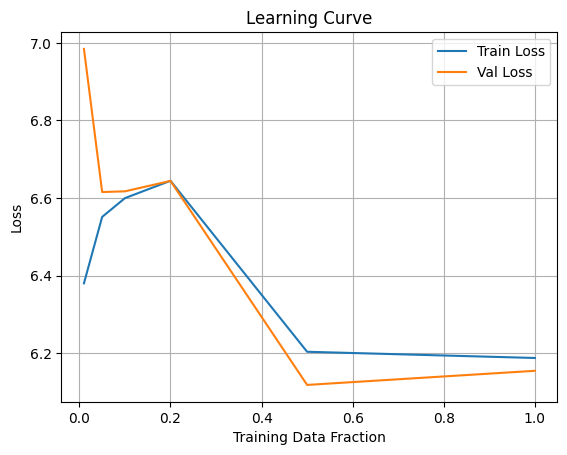

[predict] Loaded 456 rows for prediction


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_47918/854084599.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pred = pd.read_sql(query, conn)
/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_47918/854084599.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pred[bool_cols] = df_pred[bool_cols].fillna(False)



--- モデル vs 固定着順 予測精度 ---
1着: モデル=0.553  固定=0.550  (正解数: モデル=252 固定=251)
2着: モデル=0.202  固定=0.224  (正解数: モデル=92 固定=102)
3着: モデル=0.252  固定=0.211  (正解数: モデル=115 固定=96)
4着: モデル=0.191  固定=0.169  (正解数: モデル=87 固定=77)
5着: モデル=0.224  固定=0.211  (正解数: モデル=102 固定=96)
6着: モデル=0.219  固定=0.263  (正解数: モデル=100 固定=120)


In [376]:


# .ipynbを.pyに変換しておく
if __name__ == "__main__":
    import nbformat
    from nbconvert import PythonExporter

    with open("main.ipynb", "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    exporter = PythonExporter()
    source, _ = exporter.from_notebook_node(nb)

    with open("main.py", "w", encoding="utf-8") as f:
        f.write(source)


# ============================================================
# ★ 予測用スクリプト（直近3ヶ月データを使って予測） ★
# ============================================================

def predict_latest_3months():
    import datetime as dt
    today = dt.date.today()
    three_months_ago = today - dt.timedelta(days=90)

    query = f"""
        SELECT * FROM feat.train_features
        WHERE race_date BETWEEN '{three_months_ago}' AND '{today}'
    """
    df_pred = pd.read_sql(query, conn)
    print(f"[predict] Loaded {len(df_pred)} rows for prediction")

    # --- 前処理 ---
    df_pred["wind_dir_rad"] = np.deg2rad(df_pred["wind_dir_deg"])
    df_pred["wind_sin"] = np.sin(df_pred["wind_dir_rad"])
    df_pred["wind_cos"] = np.cos(df_pred["wind_dir_rad"])
    df_pred[NUM_COLS] = scaler.transform(df_pred[NUM_COLS])

    bool_cols = [c for c in df_pred.columns if c.endswith("_fs_flag")]
    df_pred[bool_cols] = df_pred[bool_cols].fillna(False)
    rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
    df_pred[rank_cols] = df_pred[rank_cols].fillna(7).astype("int32")

    pred_ds = BoatRaceDataset(df_pred, mode="zscore")
    pred_loader = DataLoader(pred_ds, batch_size=1)

    model.eval()
    for i, (ctx, boats, lane_ids, _) in enumerate(pred_loader):
        ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
        with torch.no_grad():
            scores = model(ctx, boats, lane_ids)  # (1,6)
            pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1
            # print(f"[{i:03d}] 予測順位:", pred_rank.cpu().numpy())

    # --- 追加: 固定着順との比較評価 ---
    def evaluate_against_fixed_ranks(pred_loader):
        """
        着順 [1,2,3,4,5,6] を常に予測したと仮定した場合と、モデルの予測を比較する
        """
        model_correct = [0] * 6
        fixed_correct = [0] * 6
        total = 0

        model.eval()
        for _, (ctx, boats, lane_ids, true_ranks) in enumerate(pred_loader):
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            true_ranks = true_ranks.to(device)

            with torch.no_grad():
                scores = model(ctx, boats, lane_ids)
                pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1  # (6,)

            total += 1
            for i in range(6):
                # モデルがその艇の着順を当てたか
                if pred_rank[i].item() == true_ranks[0][i].item():
                    model_correct[i] += 1
                # 固定予測 [1,2,3,4,5,6] を使った場合
                if (i + 1) == true_ranks[0][i].item():
                    fixed_correct[i] += 1

        print("\n--- モデル vs 固定着順 予測精度 ---")
        for i in range(6):
            print(f"{i+1}着: モデル={model_correct[i]/total:.3f}  固定={fixed_correct[i]/total:.3f}  (正解数: モデル={model_correct[i]} 固定={fixed_correct[i]})")

    evaluate_against_fixed_ranks(pred_loader)

# 呼び出し例
if __name__ == "__main__":
    plot_learning_curve(df, device)
    predict_latest_3months()